In [ ]:
from google.colab import files
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c store-sales-time-series-forecasting

In [ ]:
import shutil

shutil.unpack_archive("/content/train.csv.zip", "/content/train.csv", "zip")
shutil.unpack_archive("/content/transactions.csv.zip", "/content/transactions.csv", "zip")
df_train = pd.read_csv("/content/train.csv/train.csv", parse_dates = ["date"])
df_holiday = pd.read_csv("/content/holidays_events.csv", parse_dates = ["date"])
df_stores = pd.read_csv("/content/stores.csv")

In [ ]:
df_holiday = df_holiday.rename(columns = {"type": "type_holidays"})

regional = df_holiday[df_holiday.locale == "Regional"]
national = df_holiday[df_holiday.locale == "National"]
local = df_holiday[df_holiday.locale == "Local"]

holidays = [local, regional, national]

In [ ]:
df_train = df_train.merge(df_stores, left_on = "store_nbr", right_on = "store_nbr")
columns = local.drop("date", axis = 1).drop("locale_name", axis = 1).columns

In [ ]:
it_2 = 0
it_1 = 0
df_train[columns] = 0

for r in holidays:
  ls = pd.DataFrame([(date, city) for date, city in zip(r.date, r.locale_name)], columns = ["date", "city"])
  for i in range(0, len(ls.date) - 1):
    if it_1 == 0:
      df_train.loc[(df_train.date == ls.date[i]) & (df_train.city == ls.city[i]), columns] = r.drop("date", axis = 1).drop("locale_name", axis = 1).iloc[i, :].values
    elif it_1 == 1:
      df_train.loc[(df_train.date == ls.date[i]) & (df_train.state == ls.city[i]), columns] = r.drop("date", axis = 1).drop("locale_name", axis = 1).iloc[i, :].values
    else:
      df_train.loc[(df_train.date == ls.date[i]), columns] = r.drop("date", axis = 1).drop("locale_name", axis = 1).iloc[i, :].values
    it_2 += 1
  it_2 = 0
  it_1 += 1

In [ ]:
df_train.loc[df_train["transferred"] == True, ["holidays", "locale", "description"]] = 0

In [ ]:
dummies_df = pd.get_dummies(df_train[["store_nbr", "family", "type_holidays", "locale", "type", "city", "state", "cluster"]])

In [ ]:
df_train_oh = pd.concat([df_train, dummies_df], axis = 1)

In [ ]:
df_train_oh = df_train_oh.drop("description", axis = 1)

In [ ]:
df_train_oh = df_train_oh.drop("id", axis = 1)

In [ ]:
df_train_oh["y"] = df_train_oh.date.dt.year

In [ ]:
df_train_oh["dow"] = df_train_oh.date.dt.dayofweek

In [ ]:
df_train_oh["month"] = df_train_oh.date.dt.month

In [ ]:
df_train_oh.loc[df_train_oh["date"] == pd.Timestamp("2016-04-16"), ["eq"]] = 1

In [ ]:
df_train_oh = df_train_oh.drop(["store_nbr", "family", "type_holidays", "locale", "type", "dow", "city", "state", "cluster", "transferred"], axis = 1)

In [ ]:
import math
dr = pd.date_range("2016-04-17", "2016-05-17")
id = np.linspace(0, len(dr) - 1, 31)
val_df = pd.DataFrame(dr, columns = ["dr"])
val_df["id"] = id
val_df["eq"] = val_df["id"].apply(lambda x: 1/((math.exp((x-10)*0.25)+1)))

In [ ]:
df_train_oh = df_train_oh.set_index("date")
df_train_oh = pd.merge(df_train_oh, val_df, how = "left", left_index = True, right_on = "dr")
df_train_oh = df_train_oh.rename(columns = {"dr":"date"})

In [ ]:
df_oil = pd.read_csv("/content/oil.csv")
df_oil.iloc[0, 1] = df_oil.iloc[1, 1]
df_oil.date = pd.to_datetime(df_oil.date)
df_train_oh = pd.merge(df_train_oh, df_oil, how = "left", on = "date").fillna(method = "ffill")
df_train_oh = df_train_oh.set_index("date")
df_train_oh = df_train_oh.drop(["id"], axis = 1)
df_train_oh = df_train_oh.drop("eq_x", axis = 1)

In [ ]:
df_train_oh = df_train_oh.drop("holidays", axis = 1)

In [ ]:
df_train_oh.eq_y.fillna(0, inplace = True)

In [ ]:
df_train_oh.y = df_train_oh.y.replace({2013:1, 2014:2, 2015:3, 2016:4, 2017:5})

In [ ]:
df_train_oh.onpromotion -= round(df_train_oh.onpromotion.mean(), 3)
df_train_oh.onpromotion /= round(df_train_oh.onpromotion.std(), 3)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [ ]:
targets = round(np.log(df_train_oh.sales.reset_index(drop = True) + 1), 4)
df_x = df_train_oh.reset_index(drop = True).drop("sales", axis = 1)
df_x.dcoilwtico = np.log(df_x.dcoilwtico)

In [ ]:
train_range = round(int(0.75*len(targets)), 4)
train_y, train_x, valid_y, valid_x = targets[:train_range], df_x.iloc[:train_range, :], targets[train_range:], df_x.iloc[train_range:, :]

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(tree_method = "gpu_exact", predictor = "gpu_predictor", learning_rate =  0.009948916127719946, subsample= 0.9963593946651406,
    colsample_bytree = 0.8056779523100791,
    reg_alpha = 10.0,
    reg_lambda = 0.1801543144548864,
    min_child_weight = 47,
    n_estimators = 5000,
    num_boost_round=100000)
model.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], early_stopping_rounds = 500, verbose = True)

[23:54:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.50443	validation_1-rmse:3.88453
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:3.48199	validation_1-rmse:3.86032
[2]	validation_0-rmse:3.45985	validation_1-rmse:3.83644
[3]	validation_0-rmse:3.43799	validation_1-rmse:3.81277
[4]	validation_0-rmse:3.41643	validation_1-rmse:3.78948
[5]	validation_0-rmse:3.39516	validation_1-rmse:3.7665
[6]	validation_0-rmse:3.37416	validation_1-rmse:3.74373
[7]	validation_0-rmse:3.35345	validation_1-rmse:3.72132
[8]	validation_0-rmse:3.33302	validation_1-rmse:3.69907
[9]	validation_0-rmse:3.31286	validation_1-rmse:3.67726
[10]	validation_0-rmse:3.29296	validation_1-rmse:3.65566
[11]	validation_0-rmse:3.27333	validation_1-rmse:3.63424
[12]	validation_0-rmse:3.25396	validatio

XGBRegressor(colsample_bytree=0.8056779523100791,
             learning_rate=0.009948916127719946, min_child_weight=47,
             n_estimators=5000, num_boost_round=100000,
             predictor='gpu_predictor', reg_alpha=10.0,
             reg_lambda=0.1801543144548864, subsample=0.9963593946651406,
             tree_method='gpu_exact')

In [ ]:
import shap
shap.initjs()
sample = train_x.sample(10000)
predict_shap = model._Booster.predict(xgb.DMatrix(sample), pred_contribs=True)
predict_value = model.predict(sample)
shap.summary_plot(predict_shap[:,:-1], sample)

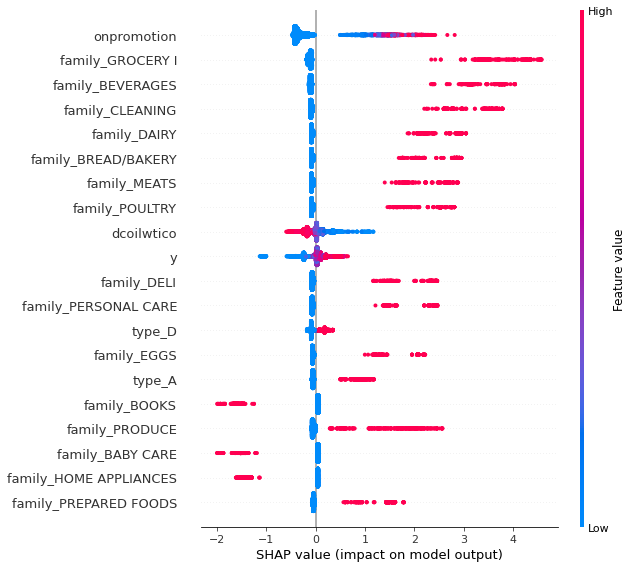

In [ ]:
shap.summary_plot(predict_shap[:,:-1], sample)

In [ ]:
explainer = shap.Explainer(model, sample)
shap_values = explainer(sample)

100%|===================| 9993/10000 [03:22<00:00]       

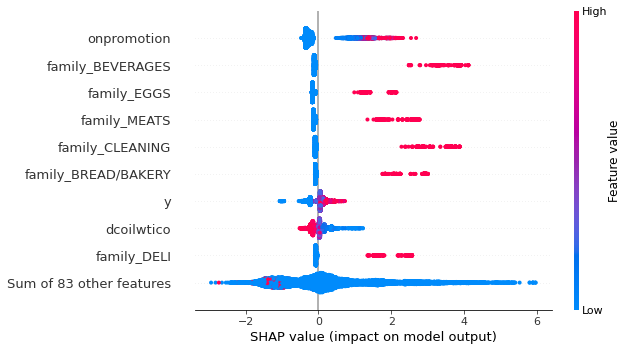

In [ ]:
shap.plots.beeswarm(shap_values)

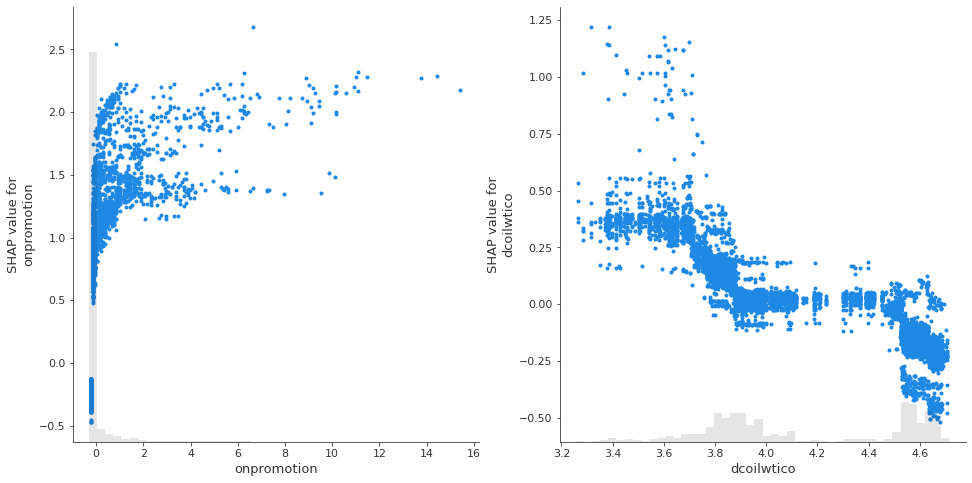

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

shap.plots.scatter(shap_values[:,"onpromotion"],ax=ax[0],show=False)
shap.plots.scatter(shap_values[:,"dcoilwtico"],ax=ax[1])

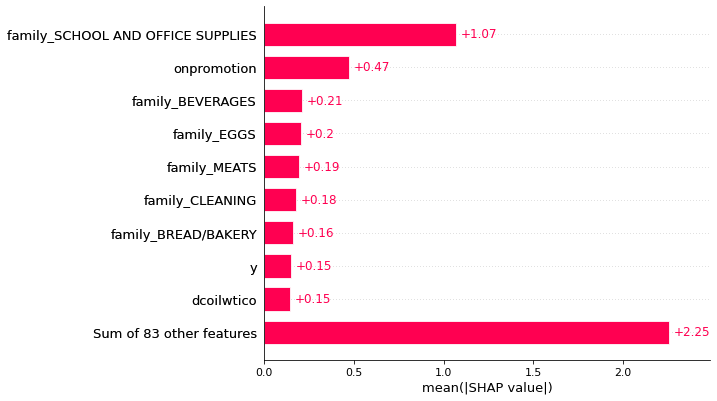

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(sample)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(sample.columns))

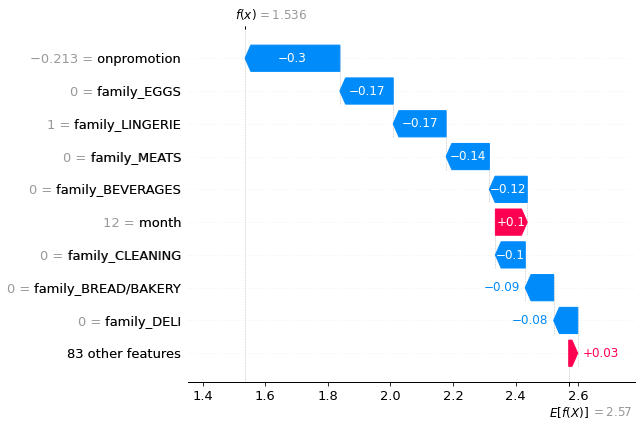

In [ ]:
shap.plots.waterfall(shap_values[1500])

In [ ]:
shap.initjs()

shap.plots.force(shap_values[5])

In [ ]:
import plotly.express as px
fig = px.line(b, x= "date", y=b.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='Percent changes of')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.show()